## Preprocessing

In [ ]:
!pip install bertopic==0.14.1

In [1]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from gensim import corpora
from gensim.models import Nmf
from gensim.models import LsiModel

from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel

In [2]:
books = ['Outlander', 'Dragonfly in Amber', 'Voyager', 'Drums of Autumn', 'The Fiery Cross', 'A Breath of Snow and Ashes',
         'An Echo in the Bone', 'Written in My Own Heart’s Blood']
extras = ['Other Books by this Author', 'About the Author']
bookstarts = [50, 17287, 37378, 61857, 89432, 119494, 152540, 177800, 202059]

In [3]:
books = []
for i in range(1, 9):
    f = open("data.txt", "r", encoding="utf8")

    book = ''
    j=0
    for line in f:
        if bookstarts[i] > j > bookstarts[i - 1]:
            book = book + line
        j+=1
    books.append(book)

In [145]:
import re

def split_into_chapters(text, i):
    if i<7:
        no_start = re.split(r'PART ONE\n\n', text)[1]
        no_end = re.split(r'ACKNOWLEDGMENTS', no_start)[0]
        return re.split(r'\n[0-9]+\n\n', no_end)
    elif i==7:
        no_start = re.split(r'PART ONE\n\n', text)[1]
        no_end = re.split(r'AUTHOR’S NOTES', no_start)[0]
        return re.split(r'\n\n\n[A-Z ]+\n\n', no_end)
    elif i==8:
        no_start = re.split(r'A HUNDREDWEIGHT OF STONES', text)[1]
        no_end = re.split(r'AUTHOR’S NOTES', no_start)[0]
        return re.split(r'\n\n\n\n\n\n', no_end)

book_chaps = []
i = 1
for book in books:
    book_chaps.append(split_into_chapters(book, i))
    i+=1

In [5]:
all_chaps = [item for sublist in book_chaps for item in sublist]

In [26]:
def prepare_corpus(clean_docs):
    dictionary = corpora.Dictionary(clean_docs)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in clean_docs]
    return dictionary,doc_term_matrix

In [27]:
from nltk.stem import WordNetLemmatizer


def preprocess_data_lem(doc_set, word95):
    tokenizer = RegexpTokenizer(r'\w+')
    en_stop = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    texts = []

    for i in doc_set:
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        stopped_tokens = [i for i in tokens if not i in en_stop]
        stemmed_tokens = [lemmatizer.lemmatize(i) for i in stopped_tokens]
        stemmed_tokens = [i for i in stemmed_tokens if not i in word95]
        texts.append(stemmed_tokens)
    return texts


In [191]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def NMF_visualisation(model_topics):
    l = len(model_topics)
    columns = 4
    rows = math.ceil(l/4)
    fig, ax = plt.subplots(rows, columns, figsize=(10, 10))
    fig.suptitle('Topic Word Scores', fontsize=30)
    fig.tight_layout(pad=2)
    ax = ax.flatten()
    colours = ['red', 'blue', 'pink', 'orange', 'green', 'purple', 'yellow']
    for index, row in model_topics:
        words_all = row.split('" + ')
        words = []
        scores = []
        for i in range(5):
            w = words_all[i]
            score = w.split('*"')[0]
            scores.append(score)
            word = w.split('*"')[1]
            words.append(word)

        y_pos = np.arange(len(words))
        scores = np.asarray(scores, dtype=float)

        pd.Series(scores).plot(kind='barh', x='LABEL',ax=ax[index], color=colours[(index-1)%7])
        ax[index].set_yticks(y_pos, labels=words)
        ax[index].invert_yaxis()
        ax[index].set_title('Topic '+str(index))

    plt.show()

    plt.savefig('NMF2.png', transparent=True,bbox_inches='tight')





## Initial

In [184]:
clean_docs=preprocess_data_lem(all_chaps, [])

dictionary,doc_term_matrix=prepare_corpus(clean_docs)
nmf_topic_model = Nmf(
        corpus = doc_term_matrix,
        id2word = dictionary,
        num_topics = 10,
        random_state = 100,
        passes=11
    )
coherencemodel = CoherenceModel(model=nmf_topic_model, texts=clean_docs, dictionary=dictionary, coherence='c_v')
score = coherencemodel.get_coherence()
03score

0.27993544660523145

In [185]:
import pandas as pd

df = pd.DataFrame(columns=['Number', 'Words'])

i=1
for topic_num, words in nmf_topic_model.show_topics():
    df.loc[i] = [topic_num, words]
    i+=1
    print('Representative words of topic {}: {}.'.format(topic_num, words))

df

Representative words of topic 0: 0.019*"ye" + 0.009*"back" + 0.008*"jamie" + 0.007*"one" + 0.007*"said" + 0.007*"hand" + 0.005*"like" + 0.005*"could" + 0.005*"though" + 0.005*"thought".
Representative words of topic 1: 0.016*"said" + 0.013*"mr" + 0.008*"one" + 0.005*"back" + 0.005*"like" + 0.005*"hand" + 0.005*"eye" + 0.004*"know" + 0.004*"well" + 0.004*"could".
Representative words of topic 2: 0.020*"said" + 0.014*"william" + 0.008*"though" + 0.006*"one" + 0.006*"would" + 0.006*"thought" + 0.006*"could" + 0.005*"back" + 0.005*"think" + 0.005*"know".
Representative words of topic 3: 0.015*"hand" + 0.014*"said" + 0.009*"could" + 0.008*"face" + 0.008*"would" + 0.007*"eye" + 0.006*"one" + 0.006*"men" + 0.006*"jamie" + 0.006*"man".
Representative words of topic 4: 0.035*"roger" + 0.013*"said" + 0.009*"brianna" + 0.006*"thought" + 0.006*"one" + 0.006*"though" + 0.005*"back" + 0.005*"like" + 0.005*"know" + 0.005*"would".
Representative words of topic 5: 0.014*"brianna" + 0.010*"jocasta" + 0.

,Number,Words
1,0,"0.019*""ye"" + 0.009*""back"" + 0.008*""jamie"" + 0...."
2,1,"0.016*""said"" + 0.013*""mr"" + 0.008*""one"" + 0.00..."
3,2,"0.020*""said"" + 0.014*""william"" + 0.008*""though..."
4,3,"0.015*""hand"" + 0.014*""said"" + 0.009*""could"" + ..."
5,4,"0.035*""roger"" + 0.013*""said"" + 0.009*""brianna""..."
6,5,"0.014*""brianna"" + 0.010*""jocasta"" + 0.009*""fra..."
7,6,"0.037*""jamie"" + 0.029*""said"" + 0.017*""ye"" + 0...."
8,7,"0.008*""one"" + 0.008*""back"" + 0.007*""could"" + 0..."
9,8,"0.022*""jamie"" + 0.009*""fraser"" + 0.008*""man"" +..."
10,9,"0.036*""ian"" + 0.020*""said"" + 0.020*""ye"" + 0.00..."


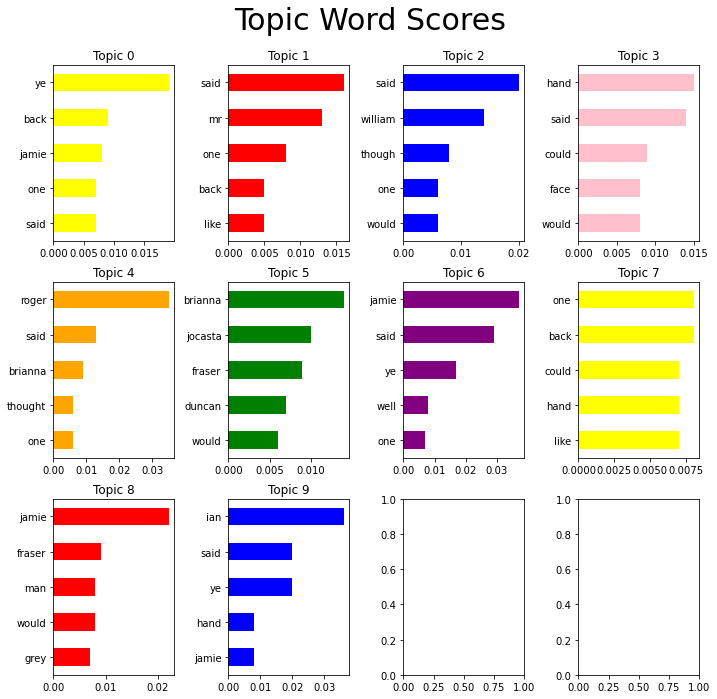

<Figure size 432x288 with 0 Axes>

In [192]:
NMF_visualisation(nmf_topic_model.print_topics())

## Remove words in 95% of chapters

In [93]:
import math

def get_95_words(chap_list):
    min_count = math.floor(0.05*len(chap_list))
    words_all = []
    for i in range(min_count):
        words_all = words_all + re.findall(r"[\w']+|[.,!?;]", chap_list[i])
    words_all = list(set([x.lower() for x in words_all]))
    words95 = []
    print(len(words_all))
    for word in words_all:
        count = 0
        for chap in chap_list:
            if word not in chap.lower():
                count += 1
        if count <= min_count:
            words95.append(word)
    return words95

In [94]:
words95 = get_95_words(all_chaps)
len(words95)

14206


197

In [97]:
clean_docs1=preprocess_data_lem(all_chaps, words95)

dictionary1,doc_term_matrix1=prepare_corpus(clean_docs1)
nmf_topic_model1 = Nmf(
        corpus = doc_term_matrix1,
        id2word = dictionary1,
        num_topics = 16,
        random_state = 100,
        passes=27
    )
coherencemodel = CoherenceModel(model=nmf_topic_model1, texts=clean_docs1, dictionary=dictionary1, coherence='c_v')
score = coherencemodel.get_coherence()
score

0.30336106951858977

In [98]:
import pandas as pd

df1 = pd.DataFrame(columns=['Number', 'Words'])

i=1
for topic_num, words in nmf_topic_model1.show_topics():
    df1.loc[i] = [topic_num, words]
    i+=1
    print('Representative words of topic {}: {}.'.format(topic_num, words))

df1

Representative words of topic 3: 0.009*"well" + 0.008*"thought" + 0.007*"know" + 0.006*"bed" + 0.006*"think" + 0.005*"bit" + 0.005*"might" + 0.005*"good" + 0.005*"small" + 0.004*"still".
Representative words of topic 14: 0.021*"mr" + 0.007*"door" + 0.006*"house" + 0.006*"face" + 0.005*"jamie" + 0.004*"small" + 0.004*"room" + 0.004*"come" + 0.004*"turned" + 0.004*"woman".
Representative words of topic 6: 0.006*"know" + 0.006*"randall" + 0.006*"well" + 0.005*"thought" + 0.005*"good" + 0.005*"get" + 0.005*"right" + 0.004*"bit" + 0.004*"stone" + 0.004*"sir".
Representative words of topic 10: 0.055*"roger" + 0.016*"brianna" + 0.008*"claire" + 0.006*"face" + 0.005*"fraser" + 0.005*"thought" + 0.005*"buck" + 0.004*"know" + 0.004*"come" + 0.004*"felt".
Representative words of topic 7: 0.038*"ian" + 0.020*"jamie" + 0.009*"young" + 0.008*"face" + 0.007*"aye" + 0.006*"jenny" + 0.006*"well" + 0.005*"looked" + 0.005*"uncle" + 0.004*"think".
Representative words of topic 15: 0.012*"jamie" + 0.005*"s

,Number,Words
1,3,"0.009*""well"" + 0.008*""thought"" + 0.007*""know"" ..."
2,14,"0.021*""mr"" + 0.007*""door"" + 0.006*""house"" + 0...."
3,6,"0.006*""know"" + 0.006*""randall"" + 0.006*""well"" ..."
4,10,"0.055*""roger"" + 0.016*""brianna"" + 0.008*""clair..."
5,7,"0.038*""ian"" + 0.020*""jamie"" + 0.009*""young"" + ..."
6,15,"0.012*""jamie"" + 0.005*""small"" + 0.005*""boy"" + ..."
7,1,"0.027*""jamie"" + 0.010*""colum"" + 0.009*""dougal""..."
8,0,"0.021*""fraser"" + 0.011*""jamie"" + 0.010*""face"" ..."
9,9,"0.019*""mr"" + 0.011*""roger"" + 0.009*""jemmy"" + 0..."
10,8,"0.033*""william"" + 0.007*""murray"" + 0.006*""thou..."


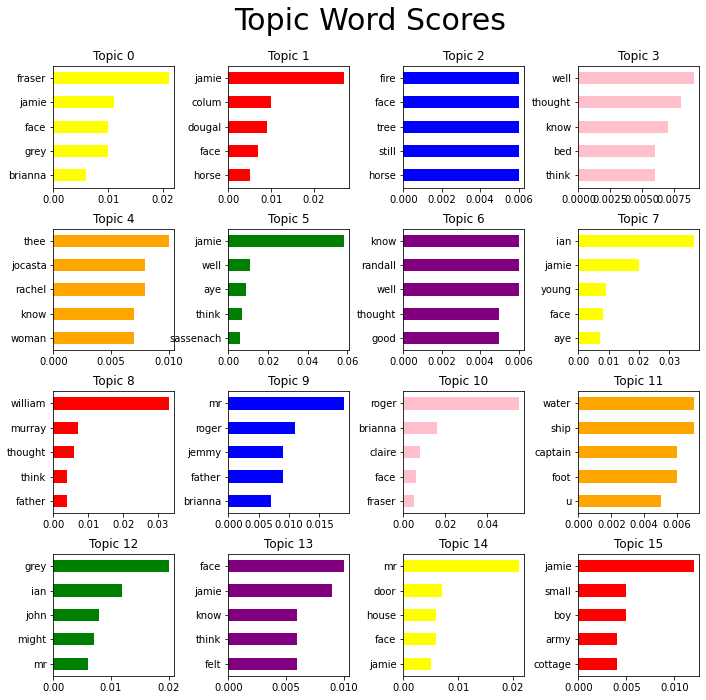

<Figure size 432x288 with 0 Axes>

In [193]:
NMF_visualisation(nmf_topic_model1.print_topics())

## And remove words that are not english

In [ ]:
import math
import PyDictionary

dictionary=PyDictionary()

def get_95_unknown_words(chap_list):
    min_count = math.floor(0.05*len(chap_list))
    words_all = []
    for i in range(len(chap_list)):
        words_all = words_all + re.findall(r"[\w']+|[.,!?;]", chap_list[i])
    words_all = list(set([x.lower() for x in words_all]))
    words95 = []
    print(len(words_all))
    for word in words_all:
        if dictionary.meaning(word,True) is None:
            words95.append(word)
            print(word)
        else:
            count = 0
            for chap in chap_list:
                if word not in chap.lower():
                    count += 1
            if count <= min_count:
                words95.append(word)
                print(word)
    return words95



In [7]:
words95unkown = get_95_words(all_chaps)
len(words95)

3445

In [ ]:
for w in words95unkown:
    with open('words95.txt', 'a') as f:
        f.write(w)
        f.write('\n')

In [108]:
words95unkown = []

with open("words95.txt", "r", encoding="utf8") as f:
    f = f.read().splitlines()
for word in f:
    words95unkown.append(word)

In [109]:
all_chaps_clean = []
for chap in all_chaps:
    chap_words = re.findall(r"[\w']+|[.,!?;]", chap)
    resultwords  = [word for word in chap_words if word.lower() not in words95unkown]
    result = ' '.join(resultwords)
    all_chaps_clean.append(result)

## BerTopic

In [39]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")
topic_model = BERTopic(nr_topics=16, vectorizer_model=vectorizer_model)
topics, probs = topic_model.fit_transform(all_chaps_clean)

In [40]:
topic_model.get_topics()

{-1: [('nodded', 0.004370569195400164),
  ('night', 0.004109490970211356),
  ('father', 0.003994274386631395),
  ('grey', 0.0039770106167579715),
  ('yes', 0.00397039639629712),
  ('seen', 0.003905949452673916),
  ('shoulder', 0.0037566451054168526),
  ('sassenach', 0.0036441008486077114),
  ('slowly', 0.0036188517507317326),
  ('god', 0.003607283301773309)],
 0: [('ship', 0.011642433909795408),
  ('deck', 0.007482699232070337),
  ('captain', 0.006900344559114202),
  ('sea', 0.00663106611060394),
  ('rail', 0.006553331033381868),
  ('stern', 0.005900655671807394),
  ('wind', 0.005218068469535213),
  ('god', 0.005116336573247222),
  ('yes', 0.004785097973473602),
  ('father', 0.004726290384881948)],
 1: [('hale', 0.005592162884632738),
  ('course', 0.00525859722865866),
  ('seen', 0.005143810647892967),
  ('higgins', 0.005075560124206726),
  ('friend', 0.0045618127583762595),
  ('matter', 0.004296650228565162),
  ('having', 0.004279369061306294),
  ('tom', 0.004271882136034325),
  ('fat

In [41]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,374,-1_nodded_night_father_grey
1,0,22,0_ship_deck_captain_sea
2,1,17,1_hale_course_seen_higgins
3,2,55,2_general_army_sir_british
4,3,26,3_father_slowly_place_old
5,4,21,4_mother_father_maybe_yes
6,5,58,5_horse_road_night_sassenach
7,6,27,6_snow_trees_bear_cabin
8,7,18,7_child_sassenach_night_dream
9,8,14,8_madame_monsieur_comte_highness


In [67]:
topic_model.visualize_barchart(top_n_topics=11)

In [ ]:
# Extract vectorizer and analyzer from BERTopic
vectorizer = topic_model.vectorizer_model
analyzer = vectorizer.build_analyzer()

# Extract features for Topic Coherence evaluation
tokens = [analyzer(doc) for doc in all_chaps_clean]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words = [[words for words, _ in topic_model.get_topic(topic)]
               for topic in range(len(set(topics))-1)]

coherence_model = CoherenceModel(topics=topic_words,
                                 texts=tokens,
                                 corpus=corpus,
                                 dictionary=dictionary,
                                 coherence='c_v')
score = coherence_model.get_coherence()
score

## NMF

In [43]:
clean_docs2=preprocess_data_lem(all_chaps, words95unkown)

dictionary2,doc_term_matrix2=prepare_corpus(clean_docs2)

KeyboardInterrupt: 

In [165]:
from gensim.models import Nmf
from numpy import Inf
# 11   39   0.32005350908909896
# 27   16   0.38781284658381565   new best 11   29   0.36210953279131564
best_passes = 1
best_num_topics = 1
best_lsa_topic_model = None
max_coherence = 0
for i in range(12,30):
  for j in range(10,41):
    nmf_topic_model2 = Nmf(
        corpus = doc_term_matrix2,
        id2word = dictionary2,
        num_topics = j,
        random_state = 11,
        passes = i,
    )
    print(i, ' ', j)
    coherencemodel = CoherenceModel(model=nmf_topic_model2, texts=clean_docs2, dictionary=dictionary2, coherence='c_v')
    score = coherencemodel.get_coherence()
    if score > max_coherence:
      max_coherence = score
      best_passes = i
      best_lsa_topic_model = nmf_topic_model2
      best_num_topics = j
      print('new best', i,' ', j,' ', score)

KeyboardInterrupt: 

In [166]:
clean_docs2=preprocess_data_lem(all_chaps_clean, words95unkown)

dictionary2,doc_term_matrix2=prepare_corpus(clean_docs2)
nmf_topic_model2 = Nmf(
        corpus = doc_term_matrix2,
        id2word = dictionary2,
        num_topics = 16,
        random_state = 11,
        passes=24
    )

In [167]:
import pandas as pd

df2 = pd.DataFrame(columns=['Number', 'Words'])

i=1
for topic_num, words in nmf_topic_model2.show_topics():
    df2.loc[i] = [topic_num, words]
    i+=1
    print('Representative words of topic {}: {}.'.format(topic_num, words))

df2

Representative words of topic 4: 0.011*"woman" + 0.011*"child" + 0.006*"mother" + 0.005*"baby" + 0.005*"snow" + 0.004*"girl" + 0.004*"year" + 0.003*"stone" + 0.003*"people" + 0.003*"tiny".
Representative words of topic 15: 0.009*"father" + 0.007*"room" + 0.005*"name" + 0.004*"table" + 0.004*"year" + 0.004*"stone" + 0.003*"glass" + 0.003*"course" + 0.003*"book" + 0.003*"maybe".
Representative words of topic 3: 0.005*"mother" + 0.004*"madame" + 0.004*"monsieur" + 0.004*"sassenach" + 0.004*"smile" + 0.003*"nodded" + 0.003*"letter" + 0.003*"stone" + 0.003*"rose" + 0.003*"paris".
Representative words of topic 14: 0.007*"sir" + 0.004*"governor" + 0.004*"hayes" + 0.003*"lieutenant" + 0.003*"soldier" + 0.003*"crowd" + 0.003*"son" + 0.003*"mountain" + 0.003*"father" + 0.003*"nodded".
Representative words of topic 10: 0.006*"road" + 0.004*"night" + 0.004*"friend" + 0.004*"indian" + 0.004*"uncle" + 0.003*"fire" + 0.003*"army" + 0.003*"general" + 0.003*"ground" + 0.003*"soldier".
Representative wo

,Number,Words
1,4,"0.011*""woman"" + 0.011*""child"" + 0.006*""mother""..."
2,15,"0.009*""father"" + 0.007*""room"" + 0.005*""name"" +..."
3,3,"0.005*""mother"" + 0.004*""madame"" + 0.004*""monsi..."
4,14,"0.007*""sir"" + 0.004*""governor"" + 0.004*""hayes""..."
5,10,"0.006*""road"" + 0.004*""night"" + 0.004*""friend"" ..."
6,2,"0.005*""word"" + 0.005*""mother"" + 0.005*""softly""..."
7,9,"0.013*""captain"" + 0.013*""ship"" + 0.009*""deck"" ..."
8,1,"0.012*""fire"" + 0.010*""tree"" + 0.007*""bear"" + 0..."
9,6,"0.010*""major"" + 0.008*""grey"" + 0.007*""fire"" + ..."
10,11,"0.006*""boy"" + 0.005*""cottage"" + 0.005*""shoulde..."


In [168]:
coherencemodel = CoherenceModel(model=nmf_topic_model2, texts=clean_docs2, dictionary=dictionary2, coherence='c_v')
score = coherencemodel.get_coherence()
score

0.385334094175618

In [169]:
nmf_topic_model2.print_topics()[0][1]

'0.013*"horse" + 0.004*"rock" + 0.003*"shoulder" + 0.003*"wall" + 0.003*"castle" + 0.003*"hill" + 0.003*"stone" + 0.003*"rain" + 0.003*"knee" + 0.003*"rupert"'

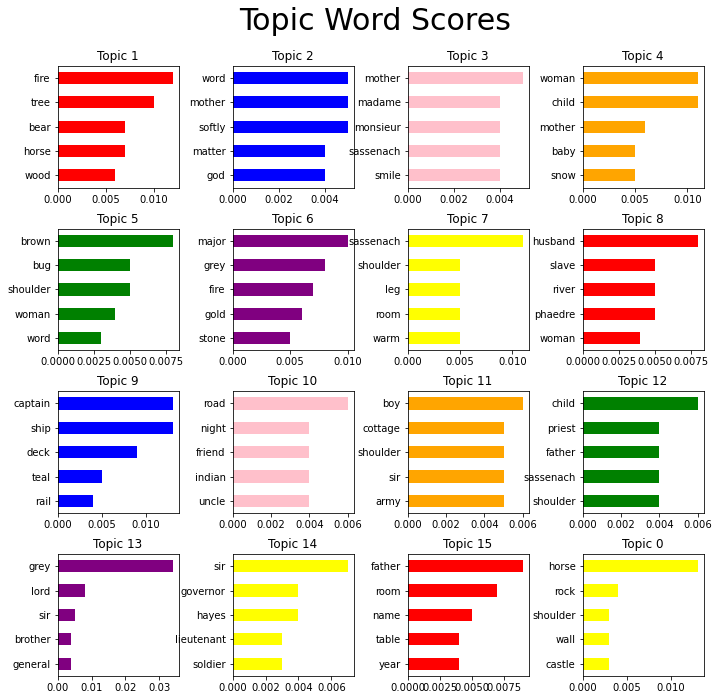

In [170]:
NMF_visualisation(nmf_topic_model2.print_topics())

## Visualise flow

In [171]:
nmf_topic_model2.get_document_topics(doc_term_matrix2[1])

[(3, 0.13712726758492202),
 (4, 0.06715037652784386),
 (6, 0.0928159803955004),
 (7, 0.10161529419530282),
 (10, 0.1425250543442955),
 (11, 0.07965897659965562),
 (12, 0.04128926988272353),
 (15, 0.31444801133644645)]

In [172]:
i=0
id_book1 = []
id_book2 = []
id_book3 = []
id_book4 = []
id_book5 = []
id_book6 = []
id_book7 = []
id_book8 = []
i=0
for doc in doc_term_matrix2:
    tops = nmf_topic_model2.get_document_topics(doc)
    id_final = 0
    pro_max = 0
    for t in tops:
        id = t[0]
        pro = t[1]
        if pro>pro_max:
            id_final = id
            pro_max = pro
    if i<42:
        id_book1.append(id_final)
    if 41<=i<92:
        id_book2.append(id_final)
    if 92<=i<156:
        id_book3.append(id_final)
    if 156<=i<228:
        id_book4.append(id_final)
    if 228<=i<340:
        id_book5.append(id_final)
    if 340<=i<456:
        id_book6.append(id_final)
    if 456<=i<562:
        id_book7.append(id_final)
    if 562<=i:
        id_book8.append(id_final)
    i+=1

In [173]:
id_books = [id_book1,id_book2,id_book3,id_book4,id_book5,id_book6,id_book7,id_book8]
y = []
for topic in range(len(nmf_topic_model2.print_topics())):
    y_x = []
    for book_n in range(0,8):
        book = id_books[book_n]
        c = book.count(topic)
        y_x.append(c)
    y.append(y_x)
y

[[18, 4, 4, 4, 8, 1, 3, 8],
 [0, 1, 0, 4, 7, 5, 1, 3],
 [7, 6, 9, 23, 14, 24, 23, 27],
 [3, 21, 6, 1, 0, 1, 3, 1],
 [1, 1, 4, 8, 6, 9, 5, 7],
 [0, 0, 0, 4, 17, 30, 13, 20],
 [3, 4, 6, 2, 3, 4, 2, 2],
 [4, 5, 10, 4, 16, 9, 1, 12],
 [0, 0, 2, 5, 11, 5, 2, 3],
 [0, 0, 12, 2, 1, 2, 3, 0],
 [1, 0, 1, 3, 2, 3, 18, 15],
 [1, 3, 1, 1, 2, 1, 3, 7],
 [2, 0, 0, 1, 6, 5, 0, 2],
 [0, 0, 4, 1, 0, 1, 15, 27],
 [0, 0, 0, 3, 12, 14, 3, 4],
 [2, 6, 5, 6, 7, 2, 11, 11]]

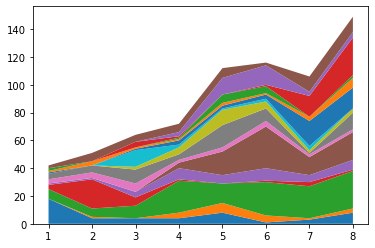

In [174]:
x=range(1,9)
plt.stackplot(x,y, labels=['A','B','C'])